In [204]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

In [205]:
sys.path.insert(1, '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# sys.path.insert(1, '/extra/stefan/utils/scrnaseq_utils/')
from scrnaseq_util_functions import *
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'

In [206]:
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'


h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
for k in ['exampledataset', 'NormanWeissman2019_raw']:
    if k in h5_files.keys(): del h5_files[k]
for k in ['PapalexiSatija2021_eccite_arrayed_protein', 'PapalexiSatija2021_eccite_protein', 'FrangiehIzar2021_protein']:
    if k in h5_files.keys(): del h5_files[k]
for k in ['gene_scores', 'ChromVar', 'LSI_embedding', 'markerpeak_target', 'peak_bc']:
    if k in h5_files.keys(): del h5_files[k]

print(len(h5_files))
list(h5_files.keys())

31


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ChangYe2021',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AdamsonWeissman2016_GSM2406675_10X001',
 'SrivatsanTrapnell2020_sciplex2',
 'SrivatsanTrapnell2020_sciplex3',
 'SrivatsanTrapnell2020_sciplex4',
 'TianKampmann2019_day7neuron',
 'TianKampmann2019_iPSC

# AdamsonWeissman2016

In [207]:
dataset = 'AdamsonWeissman2016_GSM2406681_10X010'
# adata = read_from_singles(f"{data_path}{dataset}")
adata = sc.read(f"/fast/scratch/users/peidlis_c/perturbation_resource_paper/tmp_data_{dataset}.h5")

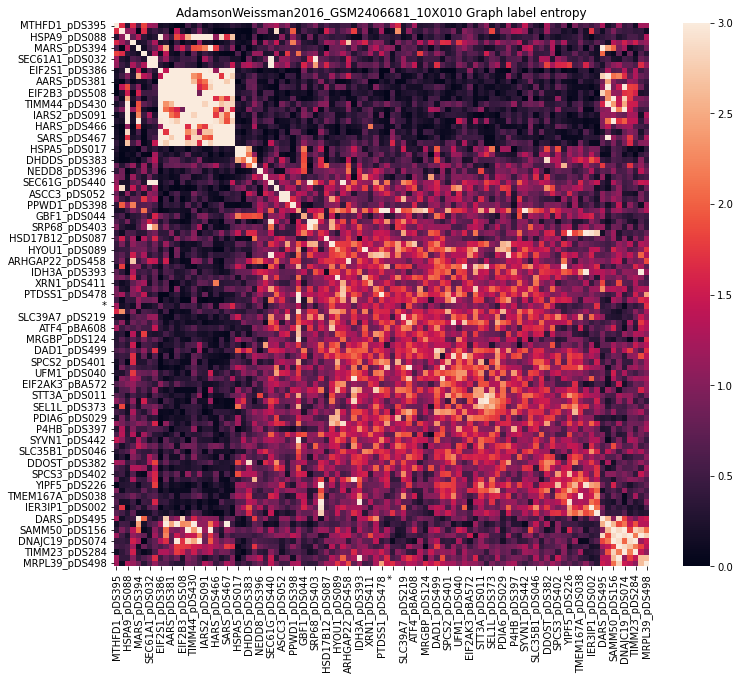

In [208]:
# Relative neighborship between cells of groups/perturbations across a KNN graph
sim = simil(adata, groupby='perturbation', plot=False, verbosity=50)
clear_output()
pl.figure(figsize=[12,10])
sns.heatmap(sim, vmax=3)
ax=pl.gca()
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
pl.title(f'{dataset} Graph label entropy')
# pl.savefig('../../figures/Graph_label_entropy_ZhaoSims2021.pdf', bbox_inches='tight')
pl.show()

## dupes

In [299]:
# we do have dups! Are they more similar to each?
targets = [x.split('_')[0] for x in sim.columns]
print(f'Found {len(sim) - len(pd.unique(targets))} duplicate targets.')
perts, cts = np.unique(targets, return_counts=True)
dups = perts[cts>1]
dups

Found 10 duplicate targets.


array(['ASCC3', 'DNAJC19', 'GBF1', 'HSPA5', 'IARS2', 'IER3IP1', 'SCYL1',
       'SEC61A1', 'SEC61B', 'YIPF5'], dtype='<U11')

In [216]:
# dict of duplicate targets : [guides]
A = {}
for dup in dups:
    A[dup] = [x for x in sim.columns if dup+'_pDS' in x]  

# Average similarity across guides with same target vs different target
tab = pd.DataFrame(index=dups, columns=['same', 'different'])
for dup in dups:
    g1, g2 = A[dup]
    tab.loc[dup, 'same'] = sim.loc[g1, g2]
    tab.loc[dup, 'different'] = np.mean(sim.loc[sim.index!=g1, sim.columns!=g2].values)

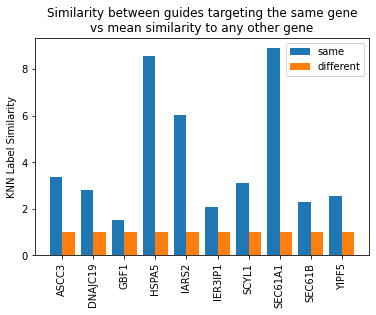

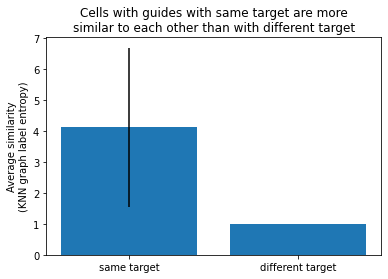

In [230]:
pl.bar(np.arange(len(tab))-0.2, tab.same, width=0.4, label='same')
pl.bar(np.arange(len(tab))+0.2, tab.different, width=0.4, label='different')
pl.legend()
pl.ylabel('KNN Label Similarity')
pl.xticks(np.arange(len(tab)), dups, rotation=90)
pl.title('Similarity between guides targeting the same gene\nvs mean similarity to any other gene')
pl.show()

pl.bar([0,1], [np.mean(tab.same), np.mean(tab.different)], yerr=[np.std(tab.same), np.std(tab.different)])
pl.ylabel('Average similarity\n(KNN graph label entropy)')
pl.xticks([0,1], ['same target', 'different target'])
pl.title('Cells with guides with same target are more\nsimilar to each other than with different target')
pl.show()

## gene groups

In [231]:
targets = [x.split('_')[0] for x in sim.columns]

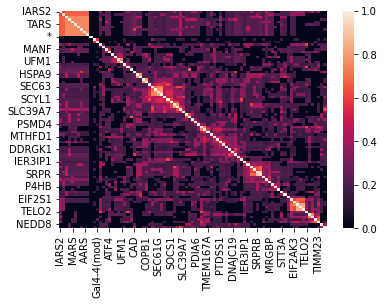

In [250]:
from difflib import SequenceMatcher
unique_targets = pd.unique(targets)
target_sim = pd.DataFrame(0, unique_targets, unique_targets)
for t1 in unique_targets:
    for t2 in unique_targets:
        s = SequenceMatcher(a=t1, b=t2).ratio()
        target_sim.loc[t1, t2] = s
target_sim = 0.5* (target_sim+target_sim.T)
target_sim = cluster_matrix(target_sim, 'both')
sns.heatmap(target_sim)
pl.show()

In [267]:
# dict of all targets : [guides]
A = {}
for target in unique_targets:
    A[target] = [x for x in sim.columns if target in x]  

In [269]:
sim_unique = pd.DataFrame(0, unique_targets, unique_targets)
for t1 in unique_targets:
    for t2 in unique_targets:
        # if we have more than one guide for target, take first only
        guide1 = A[t1][0]
        guide2 = A[t2][0]
        sim_unique.loc[t1, t2] = sim.loc[guide1, guide2]

<AxesSubplot:>

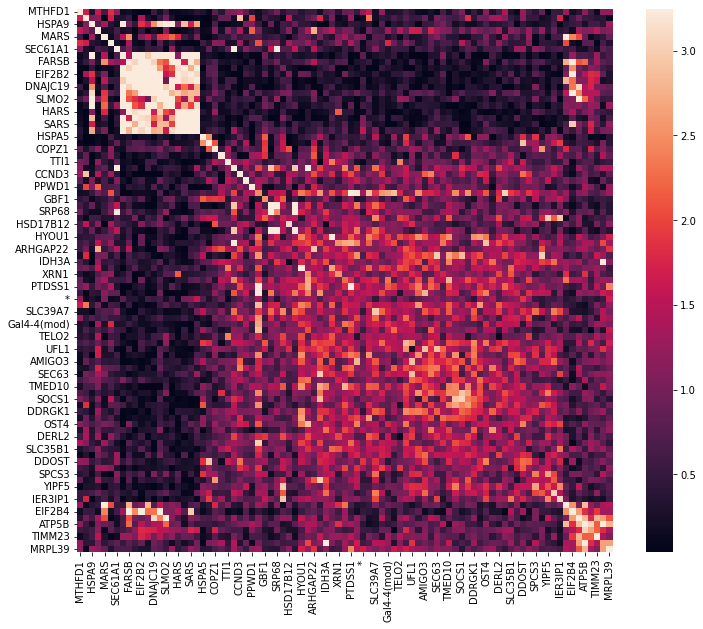

In [277]:
pl.figure(figsize=[12,10])
sns.heatmap(sim_unique, robust=True, annot_kws={"size": 8})

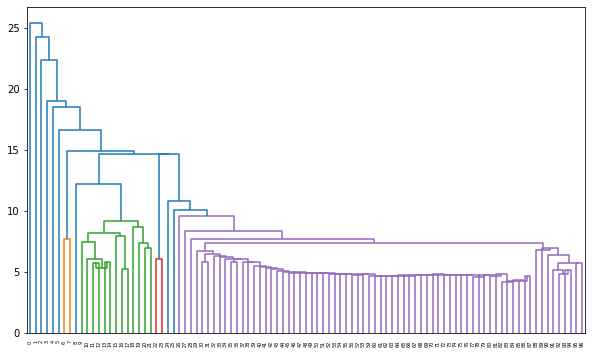

In [278]:
from scipy.cluster.hierarchy import distance, linkage, dendrogram
M = sim
method='centroid'
dist = distance.pdist(M)
link = linkage(dist, method=method)
pl.subplots(figsize=[10,6])
dend = dendrogram(link, no_plot=False, color_threshold=10)

In [279]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(sim)
labels = kmeans.labels_

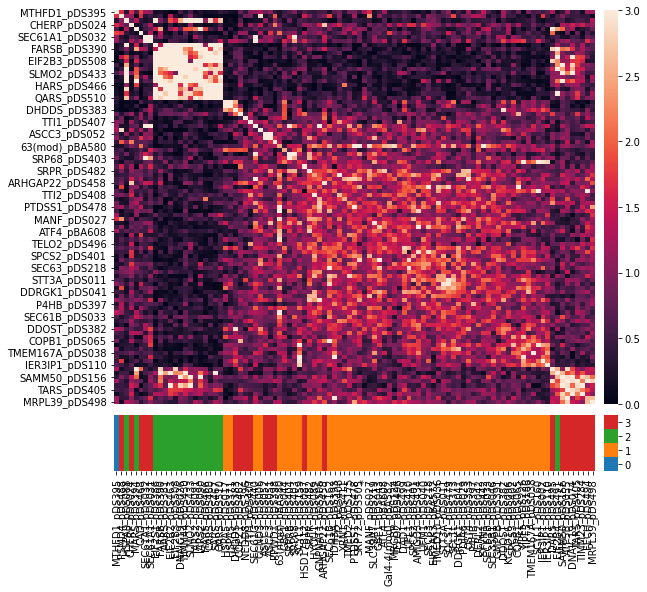

In [280]:
heatmap_with_cats(sim, labels, col_rot=90, vmax=3)

In [292]:
genes = [x.split('_')[0] for x in list(sim.columns[labels==2])]
res = gseapy_enrichr(genes, background=adata.var_names)
res.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM23401604794880,Aminoacyl-tRNA biosynthesis,8/43,2.243864e-17,2.917023e-16,359.116279,MARS;HARS;QARS;SARS;CARS;AARS;IARS2;FARSB
1,CUSTOM23397344690752,Translation Factors WP107,4/47,1.319851e-07,1.451836e-06,109.489362,EIF2S1;EIF2B2;EIF2B4;EIF2B3
2,CUSTOM23401604794880,RNA transport,4/146,1.263820e-05,8.214828e-05,35.020548,EIF2S1;EIF2B2;EIF2B4;EIF2B3
3,CUSTOM23401604794880,Herpes simplex virus 1 infection,4/369,4.600410e-04,1.993511e-03,13.654923,EIF2S1;EIF2B2;EIF2B4;EIF2B3
4,CUSTOM23397344307584,Unfolded Protein Response,2/104,5.041774e-03,2.520887e-02,21.127747,EIF2S1;HSPA9


In [294]:
genes

['HSPA9',
 'MARS',
 'EIF2S1',
 'FARSB',
 'AARS',
 'EIF2B2',
 'EIF2B3',
 'DNAJC19',
 'TIMM44',
 'SLMO2',
 'IARS2',
 'IARS2',
 'HARS',
 'CARS',
 'SARS',
 'QARS',
 'EIF2B4']

# NormanWeissman2019_filtered

In [333]:
sim = pd.read_csv('./analysis_screens/tables/graph_entropy_NormanWeissman2019_filtered_tables.csv', index_col=0)

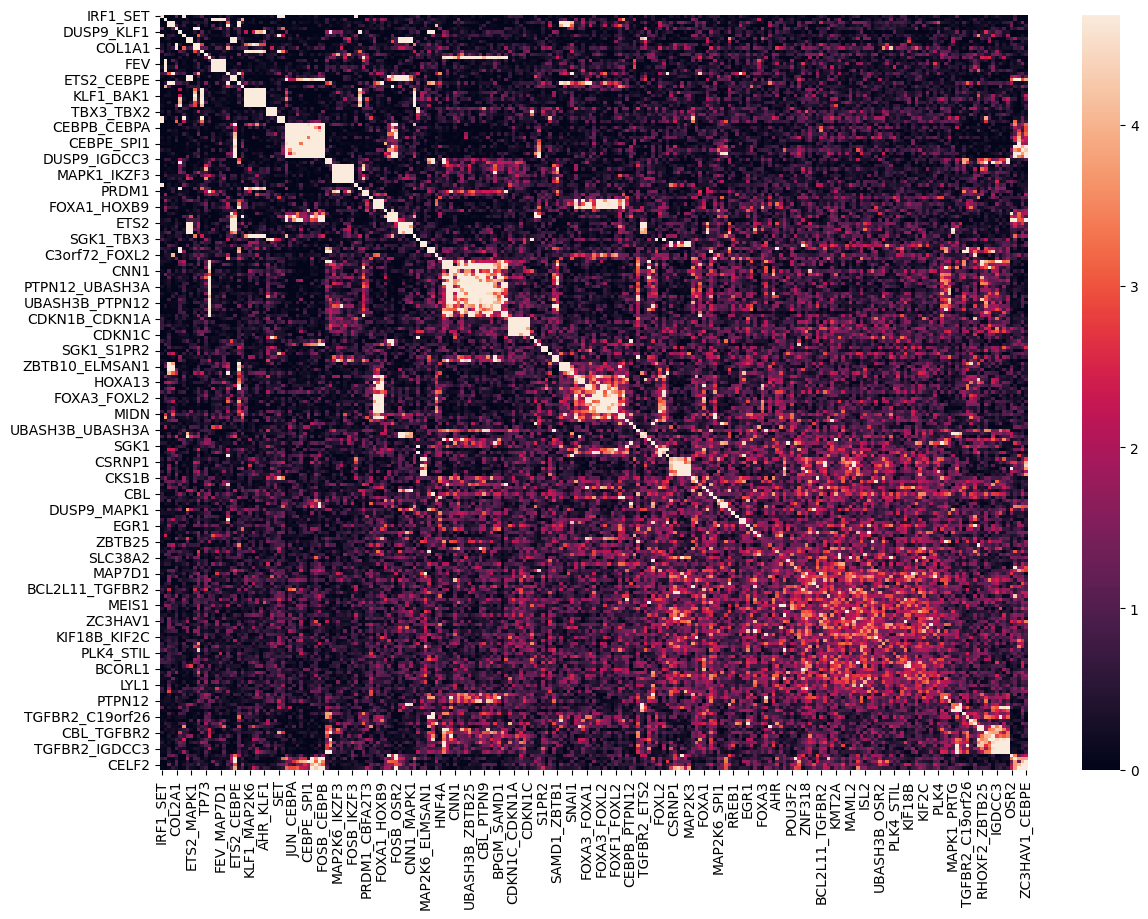

In [334]:
pl.subplots(figsize=[14,10], dpi=100)
sns.heatmap(sim, robust=True)
pl.show()

In [335]:
perturbations = sim.index

## overlaps

In [336]:
# we do have dups! Are they more similar to each?
targets = [y for x in sim.columns for y in x.split('_')]
print(f'Found {len(sim) - len(pd.unique(targets))} duplicate targets.')
perts, cts = np.unique(targets, return_counts=True)
dups = perts[cts>1]
dups

Found 131 duplicate targets.


array(['AHR', 'BAK1', 'BCL2L11', 'BPGM', 'C19orf26', 'C3orf72', 'CBFA2T3',
       'CBL', 'CDKN1A', 'CDKN1B', 'CDKN1C', 'CEBPA', 'CEBPB', 'CEBPE',
       'CLDN6', 'CNN1', 'COL2A1', 'DLX2', 'DUSP9', 'ELMSAN1', 'ETS2',
       'FEV', 'FOSB', 'FOXA1', 'FOXA3', 'FOXF1', 'FOXL2', 'HOXB9',
       'HOXC13', 'IER5L', 'IGDCC3', 'IKZF3', 'IRF1', 'ISL2', 'JUN',
       'KIF18B', 'KIF2C', 'KLF1', 'LHX1', 'LYL1', 'MAP2K3', 'MAP2K6',
       'MAP7D1', 'MAPK1', 'MEIS1', 'OSR2', 'PLK4', 'POU3F2', 'PRDM1',
       'PRTG', 'PTPN12', 'PTPN9', 'RHOXF2', 'RUNX1T1', 'S1PR2', 'SAMD1',
       'SET', 'SGK1', 'SLC38A2', 'SNAI1', 'SPI1', 'STIL', 'TBX2', 'TBX3',
       'TGFBR2', 'TMSB4X', 'UBASH3A', 'UBASH3B', 'ZBTB1', 'ZBTB10',
       'ZBTB25', 'ZC3HAV1', 'ZNF318'], dtype='<U8')

In [338]:
# dict of guides : [guides with at least one same target]
A = {}
for t in targets:
    A[t] = list(sim.columns[[t in c for c in sim.columns]])

# Average similarity across guides with same target vs different target
tab = pd.DataFrame(index=targets, columns=['same', 'different'])
for t in targets:
    a = A[t]
    tab.loc[t, 'same'] = np.mean(sim.loc[a, a].values)
    tab.loc[t, 'different'] = np.mean(sim.loc[~np.isin(sim.index, a), ~np.isin(sim.index, a)].values)

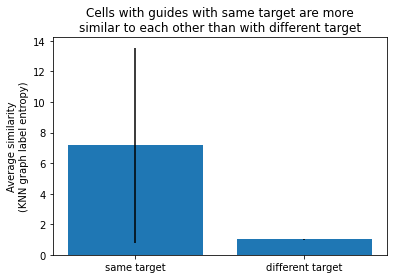

In [341]:
# pl.bar(np.arange(len(tab))-0.2, tab.same, width=0.4, label='same')
# pl.bar(np.arange(len(tab))+0.2, tab.different, width=0.4, label='different')
# pl.legend()
# pl.ylabel('KNN Label Similarity')
# pl.xticks(np.arange(len(tab)), targets, rotation=90)
# pl.title('Similarity between guides targeting the same gene\nvs mean similarity to any other gene')
# pl.show()

pl.bar([0,1], [np.mean(tab.same), np.mean(tab.different)], yerr=[np.std(tab.same), np.std(tab.different)])
pl.ylabel('Average similarity\n(KNN graph label entropy)')
pl.xticks([0,1], ['same target', 'different target'])
pl.title('Cells with guides with same target are more\nsimilar to each other than with different target')
pl.show()

# ATAC

In [14]:
atac_h5_files = {}
for path, subdirs, files in os.walk(f'{data_path}/scATAC/'):
    for name in files:
        if '.h5' in name: atac_h5_files[name[:-3]] = os.path.join(path, name)

print(len(atac_h5_files))
list(atac_h5_files.keys())

5


['gene_scores', 'peak_bc', 'ChromVar', 'LSI_embedding', 'markerpeak_target']

In [166]:
get_subfolders(f'{data_path}/scATAC/', False)

['Liscovitch-BrauerSanjana2021', 'MimitouSmibert2021', 'PierceGreenleaf2021']

In [189]:
adata = read_from_singles(f'{data_path}/scATAC/MimitouSmibert2021/{line}/gene_scores/')

In [191]:
adata.X

<10018x24919 sparse matrix of type '<class 'numpy.float32'>'
	with 99358749 stored elements in Compressed Sparse Row format>

In [196]:
99358749 / (10018 * 24919)

0.3980104522481949

In [201]:
rsum(adata.X, axis=0)

array([   0.     ,    0.     ,    0.     , ...,    1.748  ,  383.80713,
       1699.1522 ], dtype=float32)

## gene scores

In [158]:
def gene_scores(dataset, line, ax=None, show=False):
    mode = 'gene_scores'
    adata = read_from_singles(f'{data_path}/scATAC/{dataset}/{line}/{mode}/')
    adata = adata[~pd.isna(adata.obs.perturbation)].copy()

    # calc_qc(adata)
    # obs_qc_cross_plots(adata, obs_keys=['ncounts', 'ngenes'])

    # basic qc and pp
    sc.pp.filter_cells(adata, min_genes=500)
    sc.pp.filter_genes(adata, min_cells=50)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=50)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    skb = SelectKBest(chi2, k=2000).fit(adata.X, adata.obs.perturbation)
    features = [int(x[1:]) for x in skb.get_feature_names_out()]
    adata.var['highly_variable'] = False
    adata.var['highly_variable'][features] = True

    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)
    
    # Relative neighborship between cells of groups/perturbations across a KNN graph
    sim = simil(adata, groupby='perturbation', plot=False, verbosity=0)
    
    if ax==None:
        pl.figure(figsize=[12,10])
        ax=pl.gca()
    sns.heatmap(sim, robust=True, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(f'scATAC {dataset} {line} {mode} Graph label entropy')
    # pl.savefig('../../figures/Graph_label_entropy_ZhaoSims2021.pdf', bbox_inches='tight')
    if show: pl.show()
    return sim

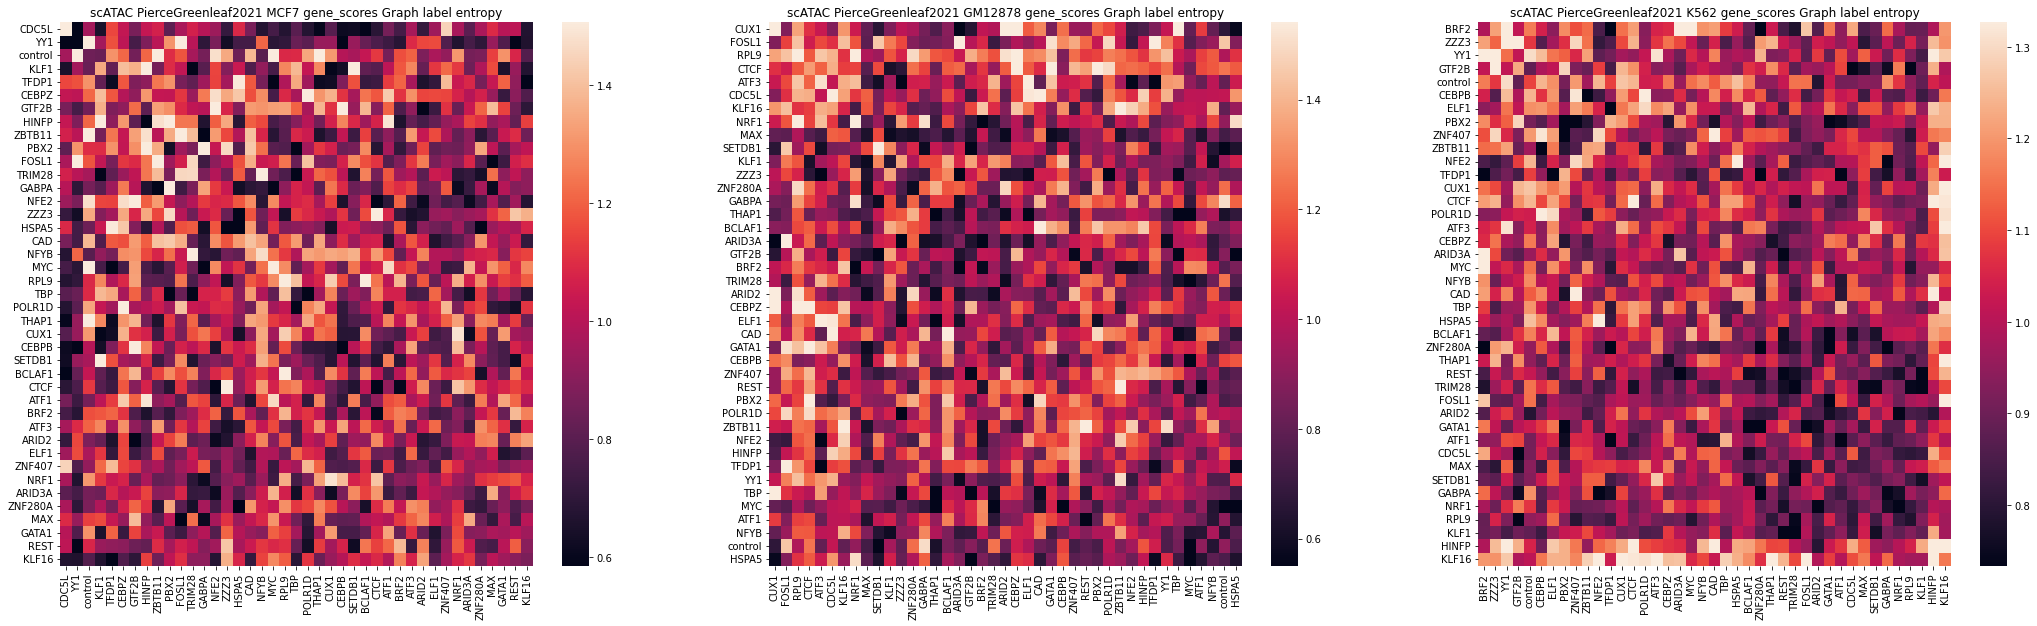

In [157]:
fig, axs = pl.subplots(1, len(lines), figsize=[12*len(lines), 10])
sims = {}
for line, ax in zip(lines, axs):
    sims[f'{dataset}_{line}_gene_scores'] = gene_scores(dataset, line, ax=ax, show=False)

## peak_bc

In [159]:
def peak_bc(dataset, line, ax=None, show=False):
    mode = 'peak_bc'
    adata = read_from_singles(f'{data_path}/scATAC/{dataset}/{line}/{mode}/')
    adata = adata[~pd.isna(adata.obs.perturbation)].copy()

    # calc_qc(adata)
    # obs_qc_cross_plots(adata, obs_keys=['ncounts', 'ngenes'])

    # basic qc and pp
    adata.layers['counts'] = adata.X.copy()
    sc.pp.filter_cells(adata, min_counts=200)
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=25)
    sc.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    adata.shape

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=50)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')

    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)
    
    # Relative neighborship between cells of groups/perturbations across a KNN graph
    sim = simil(adata, groupby='perturbation', plot=False, verbosity=0)
    
    if ax==None:
        pl.figure(figsize=[12,10])
        ax=pl.gca()
    sns.heatmap(sim, robust=True, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(f'scATAC {dataset} {line} {mode} Graph label entropy')
    # pl.savefig('../../figures/Graph_label_entropy_ZhaoSims2021.pdf', bbox_inches='tight')
    if show: pl.show()
    return sim

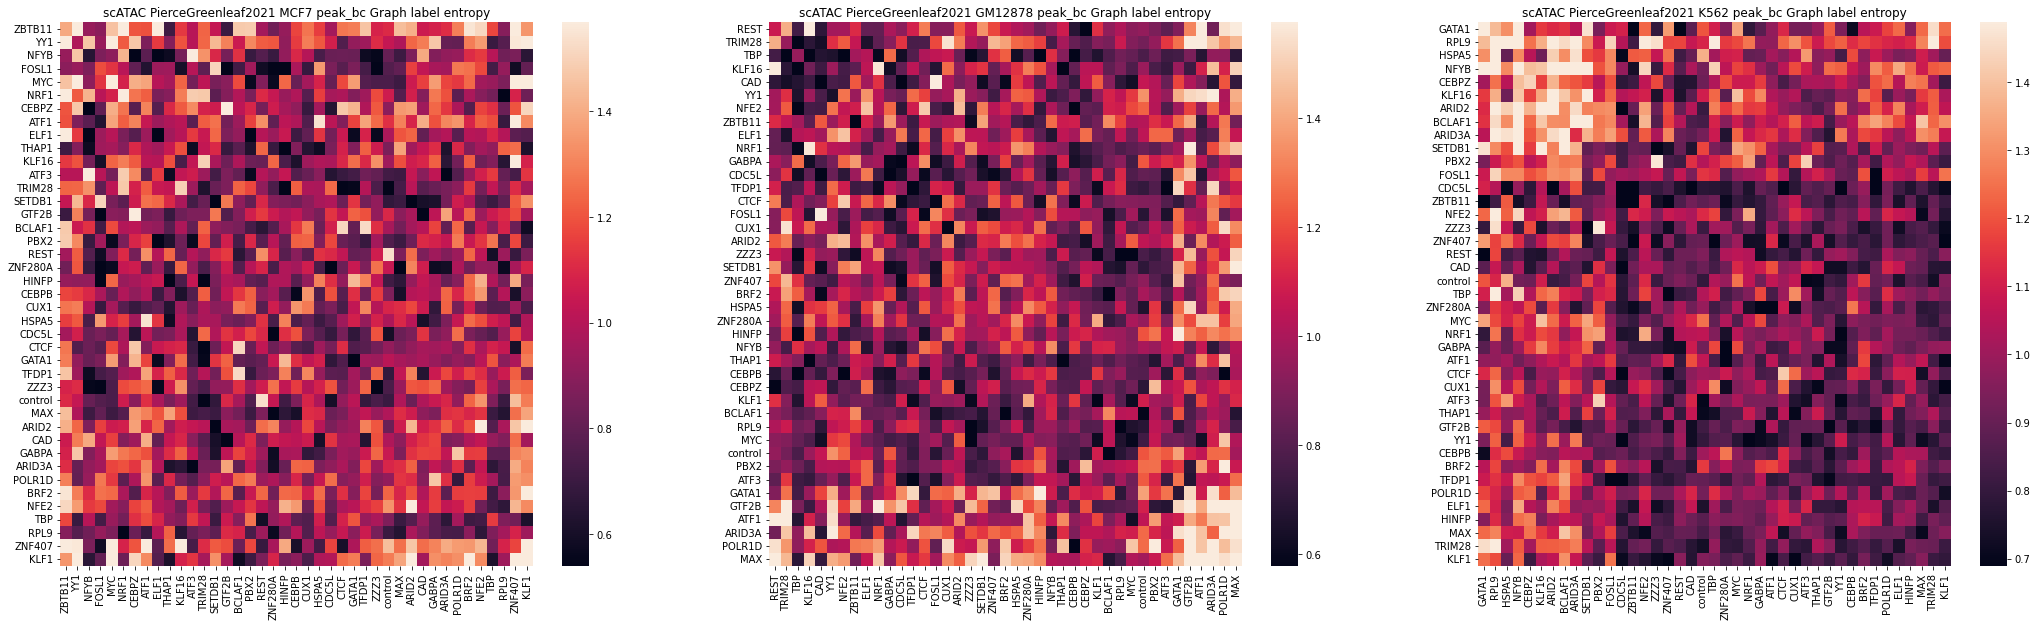

In [160]:
fig, axs = pl.subplots(1, len(lines), figsize=[12*len(lines), 10])
sims = {}
for line, ax in zip(lines, axs):
    sims[f'{dataset}_{line}_peak_bc'] = peak_bc(dataset, line, ax=ax, show=False)

## ChromVar

In [161]:
def ChromVar(dataset, line, ax=None, show=False):
    mode = 'ChromVar'
    adata = read_from_singles(f'{data_path}/scATAC/{dataset}/{line}/{mode}/')
    adata = adata[~pd.isna(adata.obs.perturbation)].copy()

    # calc_qc(adata)
    # obs_qc_cross_plots(adata, obs_keys=['ncounts', 'ngenes'])

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=50)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    sc.pp.pca(adata, use_highly_variable=False)
    sc.pp.neighbors(adata)
    
    # Relative neighborship between cells of groups/perturbations across a KNN graph
    sim = simil(adata, groupby='perturbation', plot=False, verbosity=0)
    
    if ax==None:
        pl.figure(figsize=[12,10])
        ax=pl.gca()
    sns.heatmap(sim, robust=True, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(f'scATAC {dataset} {line} {mode} Graph label entropy')
    # pl.savefig('../../figures/Graph_label_entropy_ZhaoSims2021.pdf', bbox_inches='tight')
    if show: pl.show()
    return sim

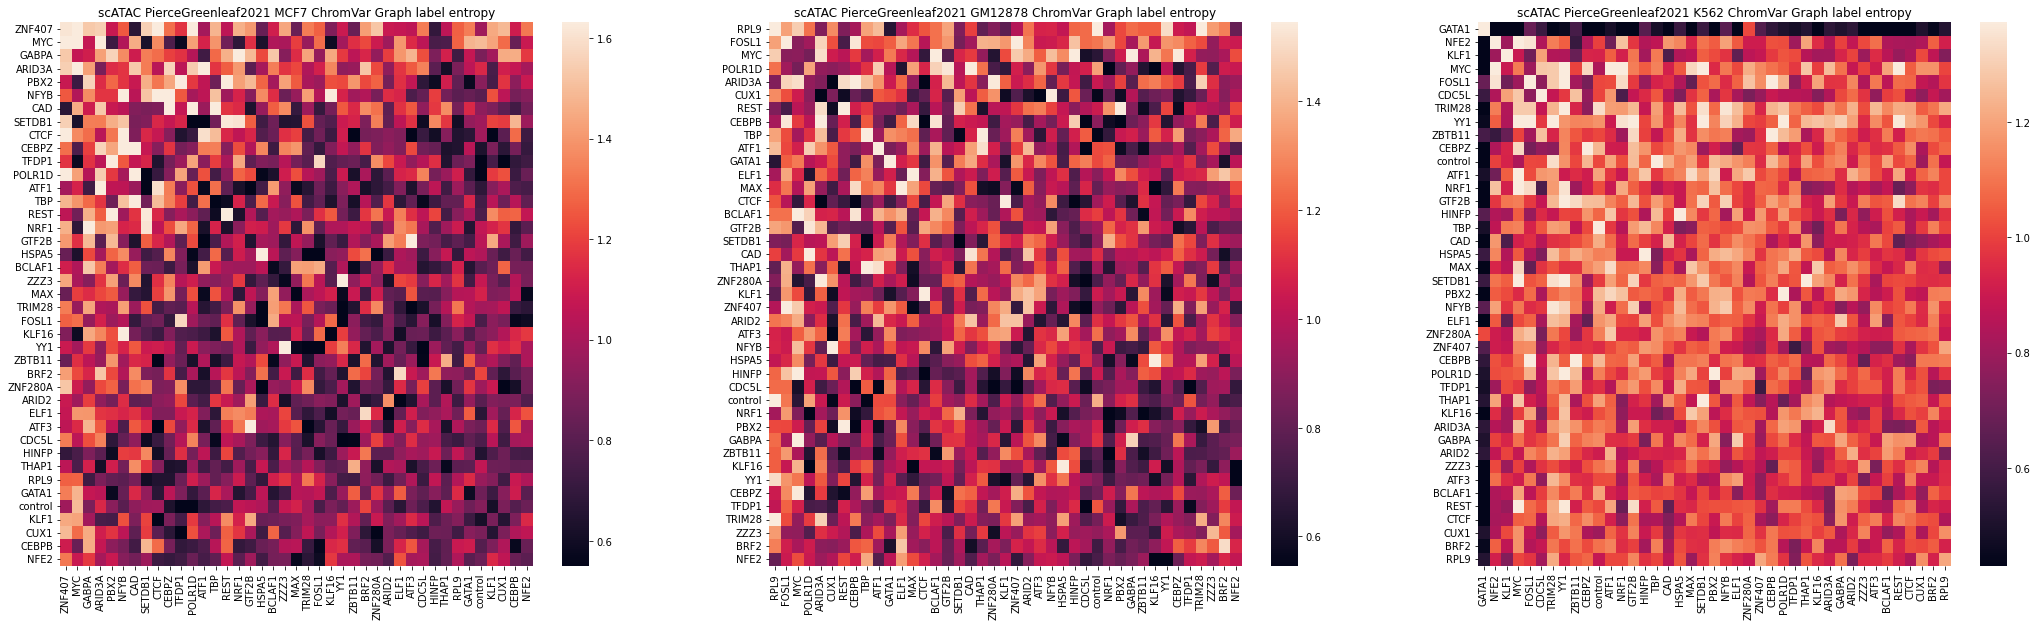

In [162]:
fig, axs = pl.subplots(1, len(lines), figsize=[12*len(lines), 10])
sims = {}
for line, ax in zip(lines, axs):
    sims[f'{dataset}_{line}_ChromVar'] = ChromVar(dataset, line, ax=ax, show=False)

## LSI_embedding

In [163]:
def LSI_embedding(dataset, line, ax=None, show=False):
    mode = 'LSI_embedding'
    adata = read_from_singles(f'{data_path}/scATAC/{dataset}/{line}/{mode}/')
    adata = adata[~pd.isna(adata.obs.perturbation)].copy()

    # calc_qc(adata)
    # obs_qc_cross_plots(adata, obs_keys=['ncounts', 'ngenes'])

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=50)
    sc.pp.neighbors(adata, use_rep='X')
    
    # Relative neighborship between cells of groups/perturbations across a KNN graph
    sim = simil(adata, groupby='perturbation', plot=False, verbosity=0)
    
    if ax==None:
        pl.figure(figsize=[12,10])
        ax=pl.gca()
    sns.heatmap(sim, robust=True, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(f'scATAC {dataset} {line} {mode} Graph label entropy')
    # pl.savefig('../../figures/Graph_label_entropy_ZhaoSims2021.pdf', bbox_inches='tight')
    if show: pl.show()
    return sim

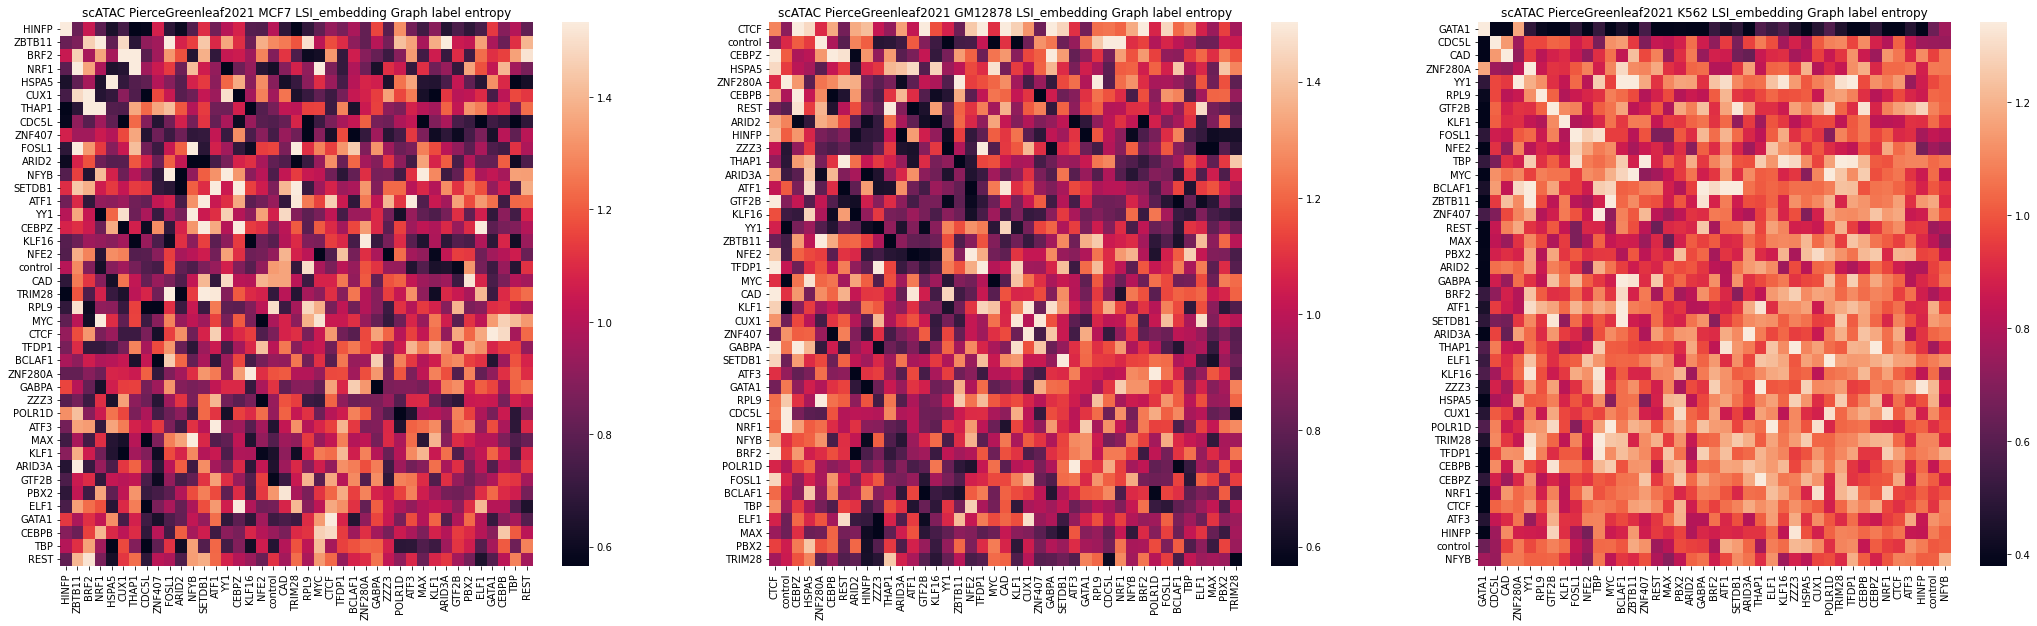

In [164]:
fig, axs = pl.subplots(1, len(lines), figsize=[12*len(lines), 10])
sims = {}
for line, ax in zip(lines, axs):
    sims[f'{dataset}_{line}_LSI_embedding'] = LSI_embedding(dataset, line, ax=ax, show=False)

## all

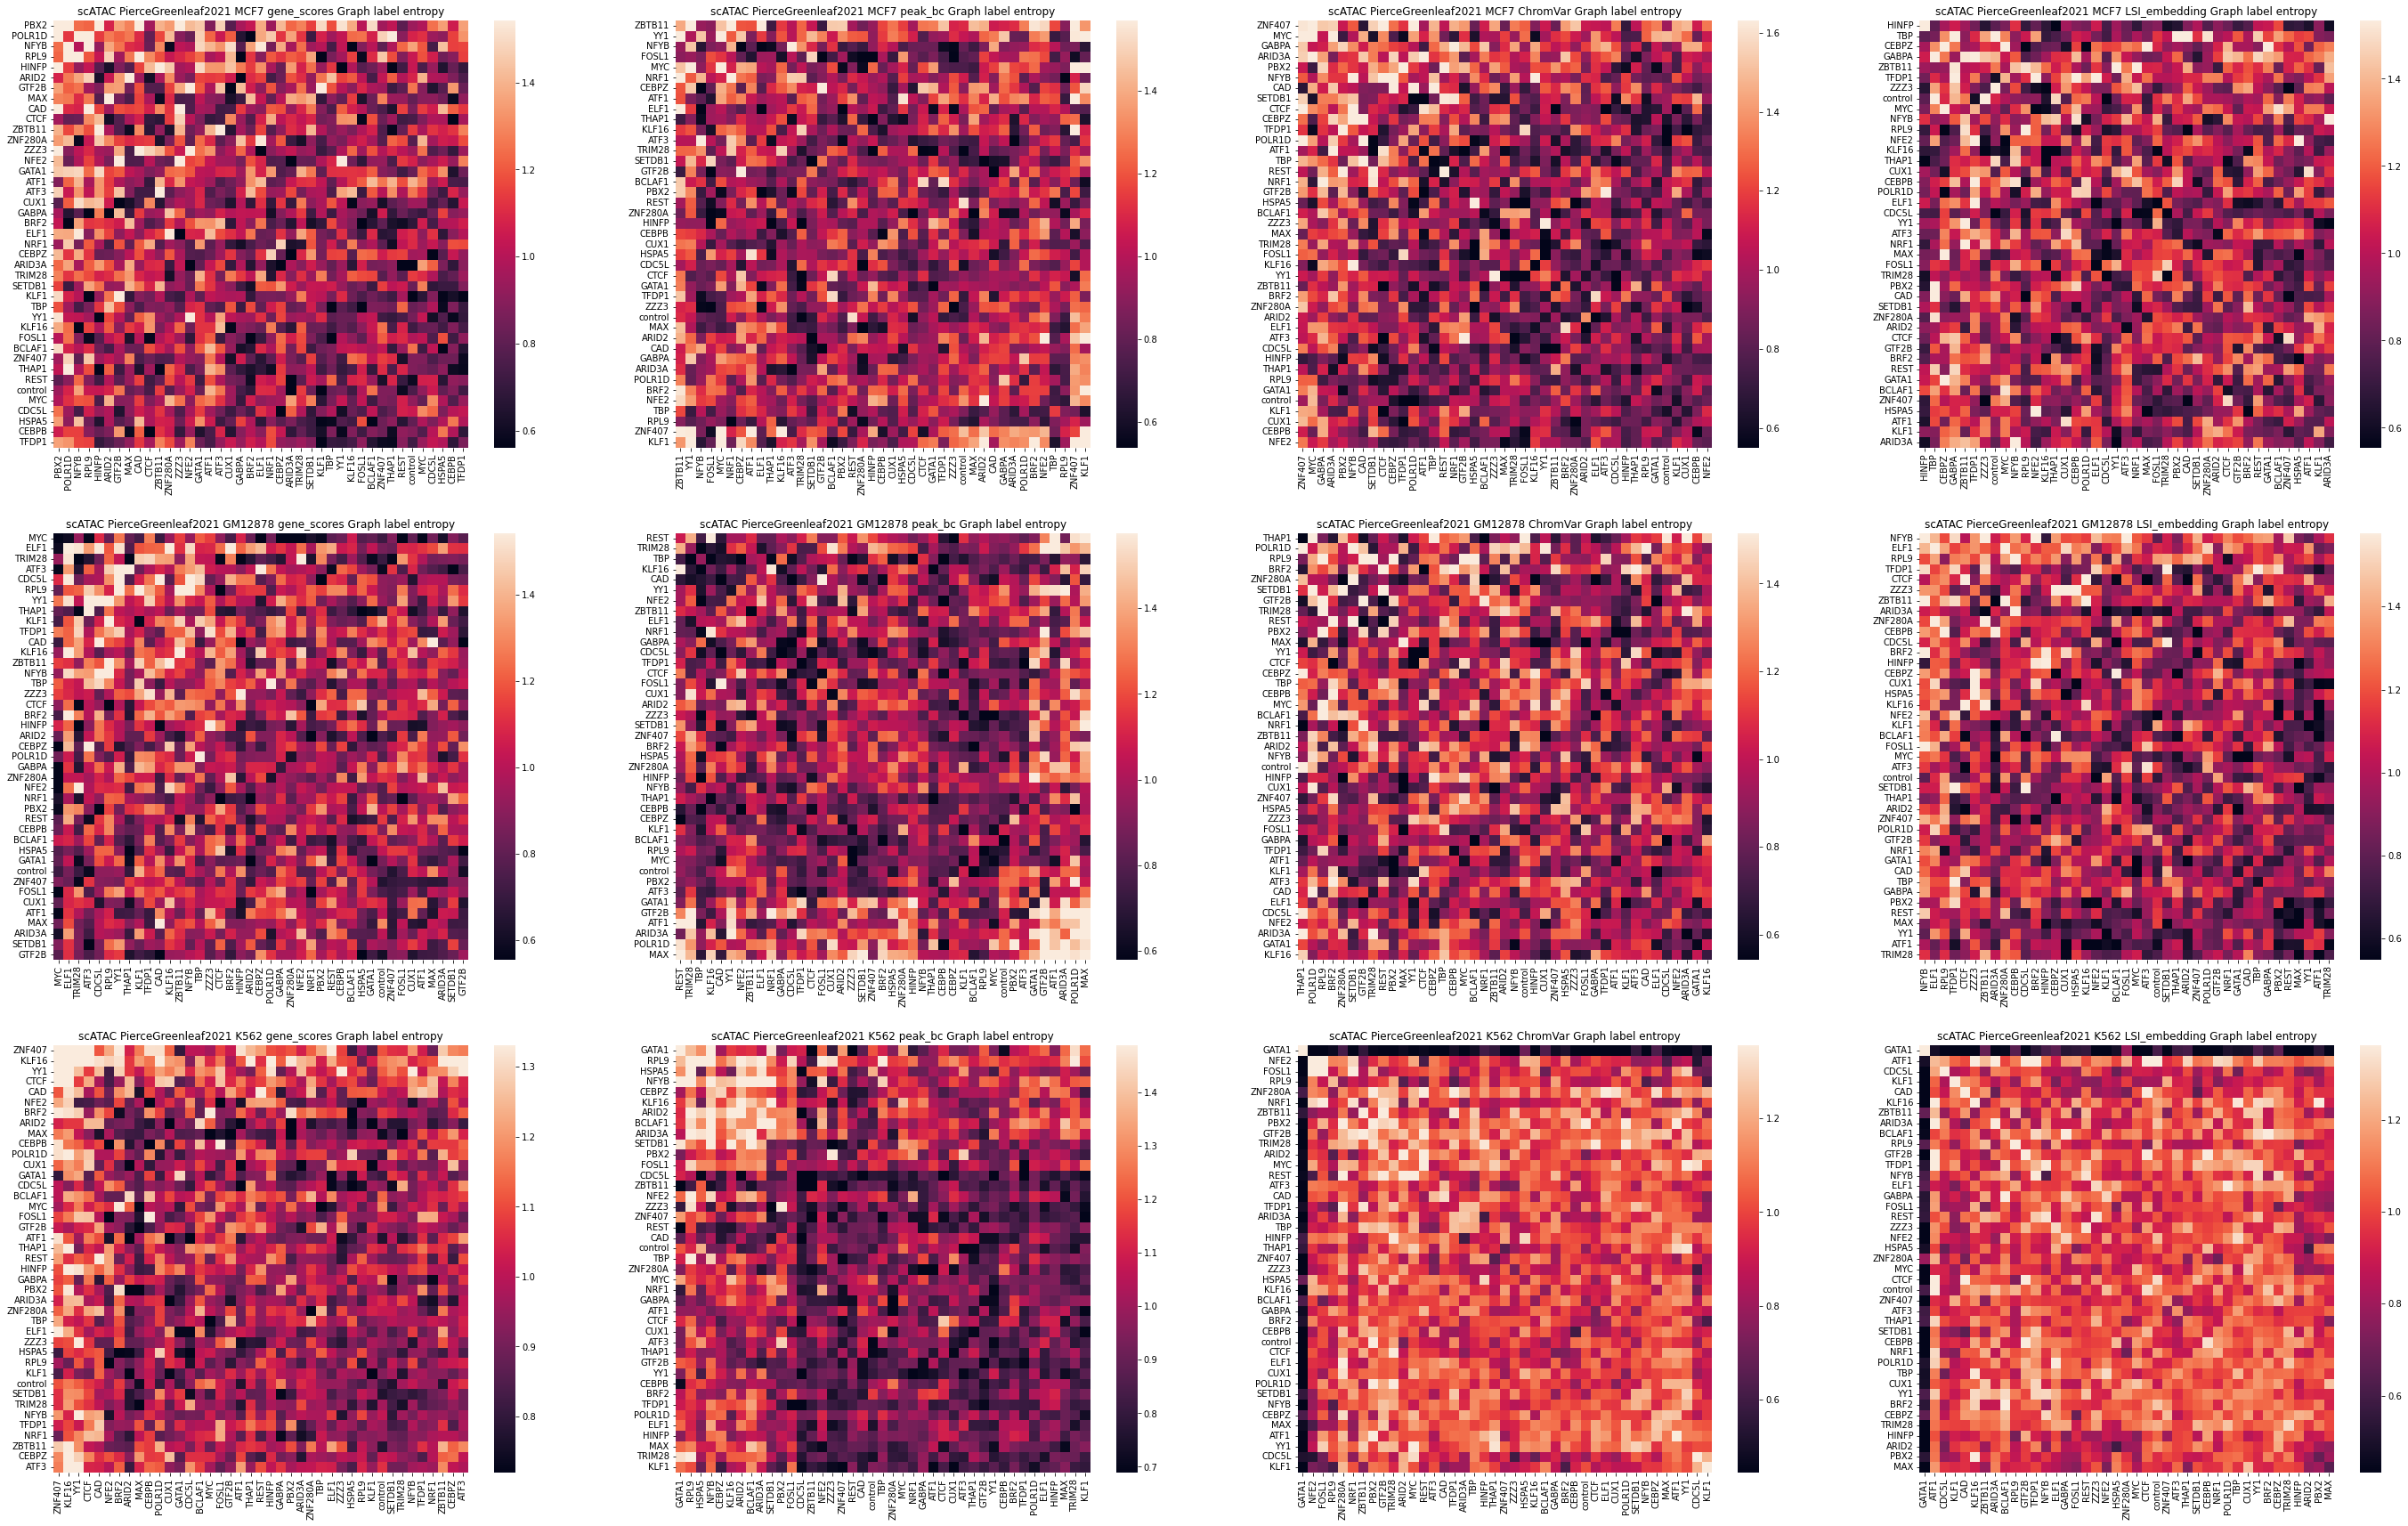

In [178]:
modes = ['gene_scores', 'peak_bc', 'ChromVar', 'LSI_embedding']  # markerpeak_target
dataset = 'PierceGreenleaf2021'
lines = get_subfolders(f'{data_path}/scATAC/{dataset}', False)
fig, axss = pl.subplots(len(lines), 4, figsize=[12 * 4, 10*len(lines)])
sims = {}
for line, axs in zip(lines, axss):
    for mode, ax in zip(modes, axs):
        fct = eval(mode)
        sims[f'{dataset}_{line}_{mode}'] = fct(dataset, line, ax=ax, show=False)
pl.savefig(f'scATAC_{dataset}_graph_label_entropy.pdf')
pl.show()

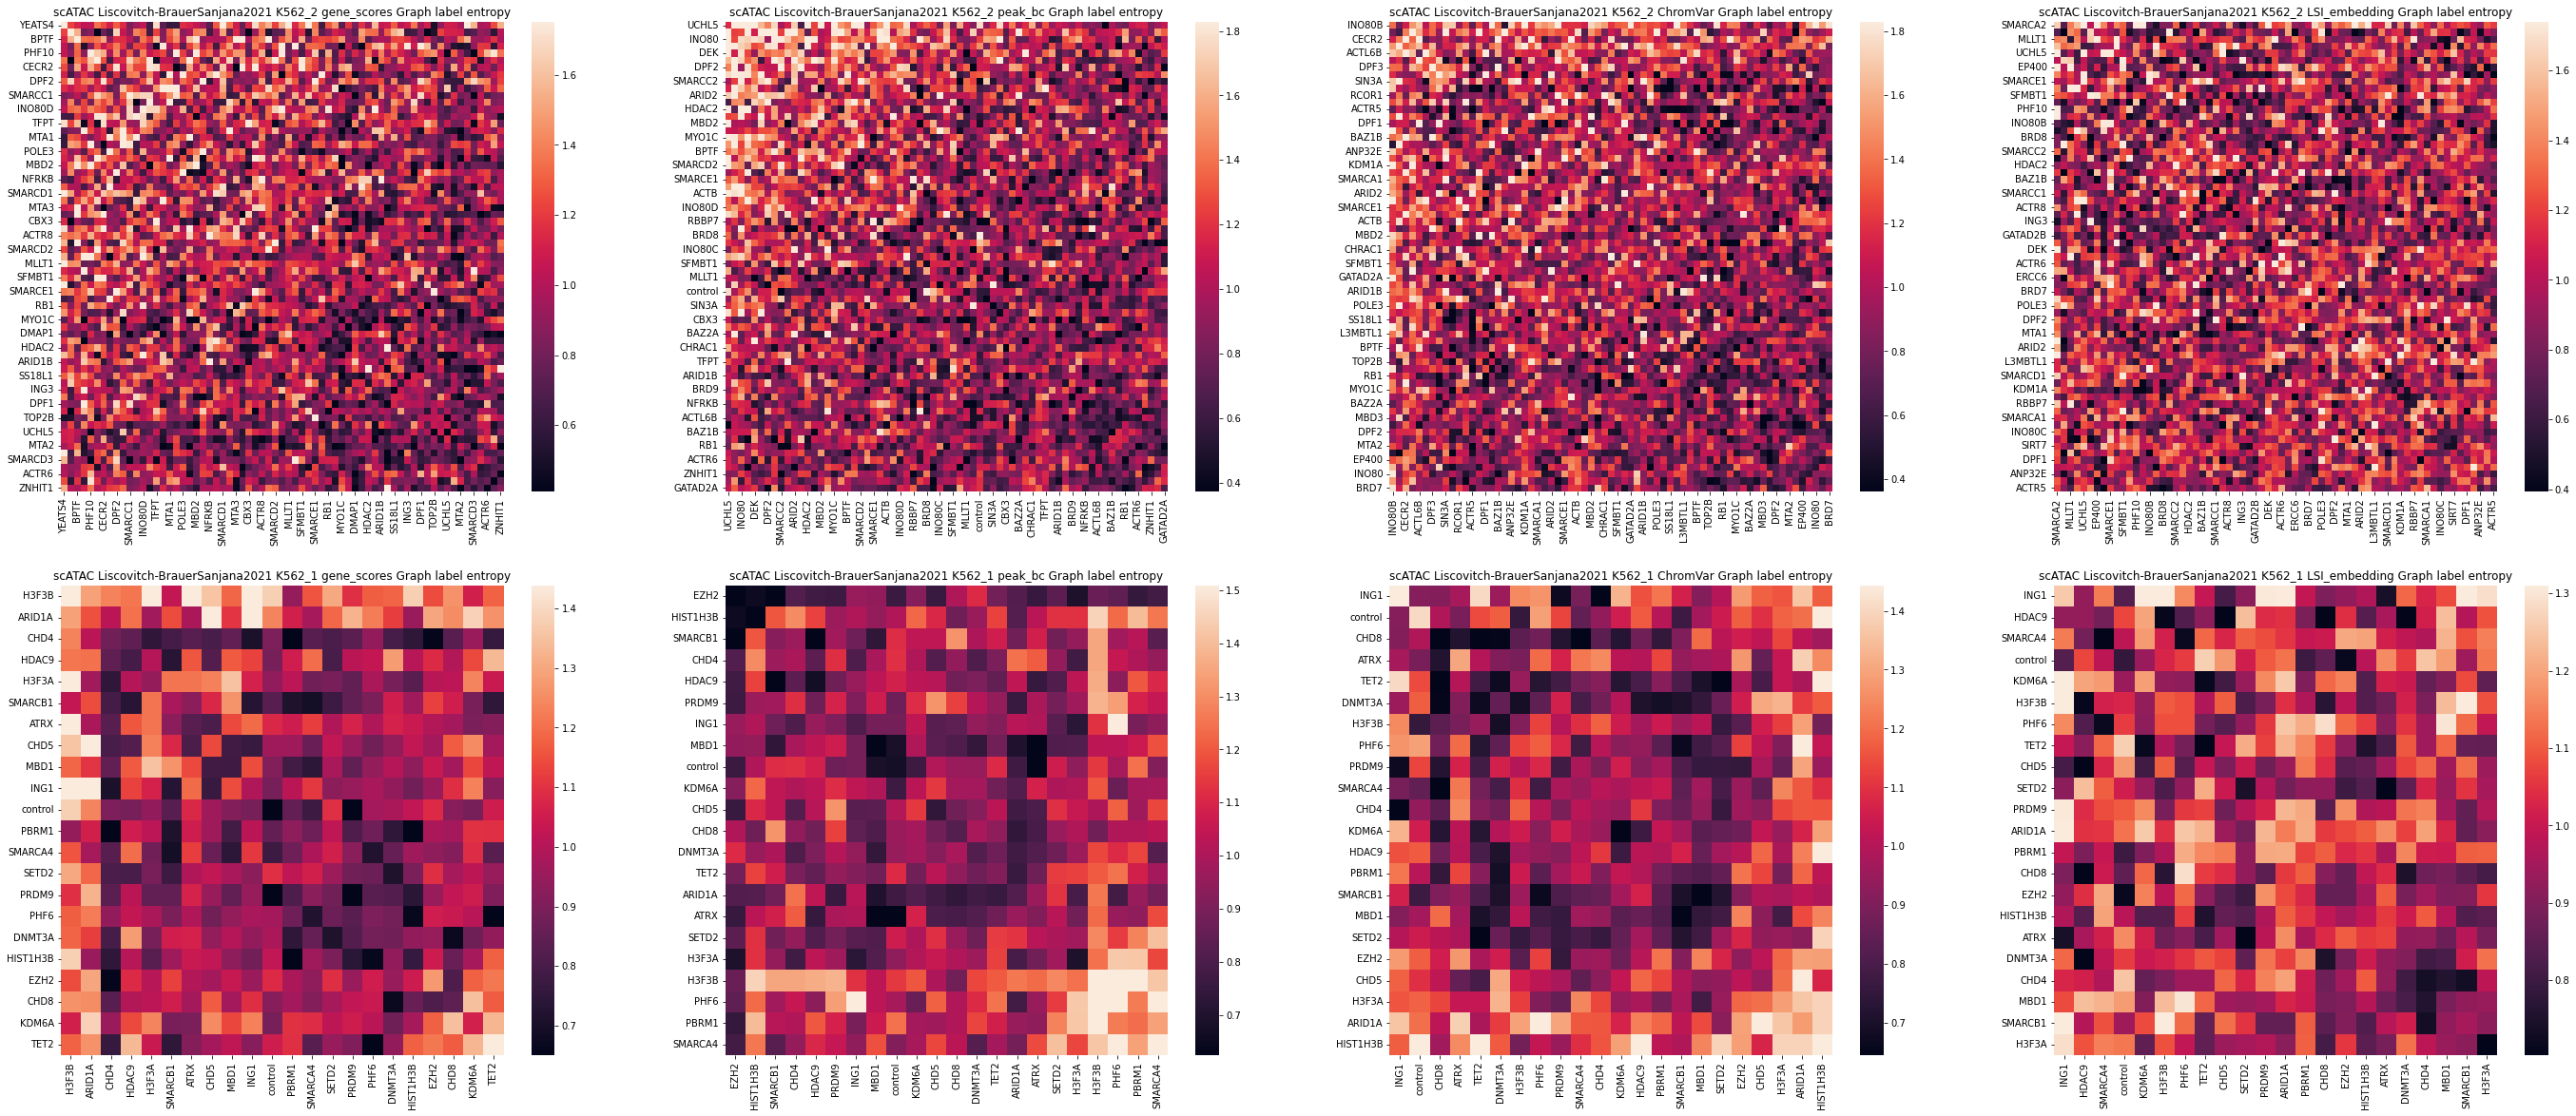

In [179]:
modes = ['gene_scores', 'peak_bc', 'ChromVar', 'LSI_embedding']  # markerpeak_target
dataset = 'Liscovitch-BrauerSanjana2021'
lines = get_subfolders(f'{data_path}/scATAC/{dataset}', False)
fig, axss = pl.subplots(len(lines), 4, figsize=[12 * 4, 10 * len(lines)])
sims = {}
for line, axs in zip(lines, axss):
    for mode, ax in zip(modes, axs):
        fct = eval(mode)
        sims[f'{dataset}_{line}_{mode}'] = fct(dataset, line, ax=ax, show=False)
pl.savefig(f'scATAC_{dataset}_graph_label_entropy.pdf')
pl.show()

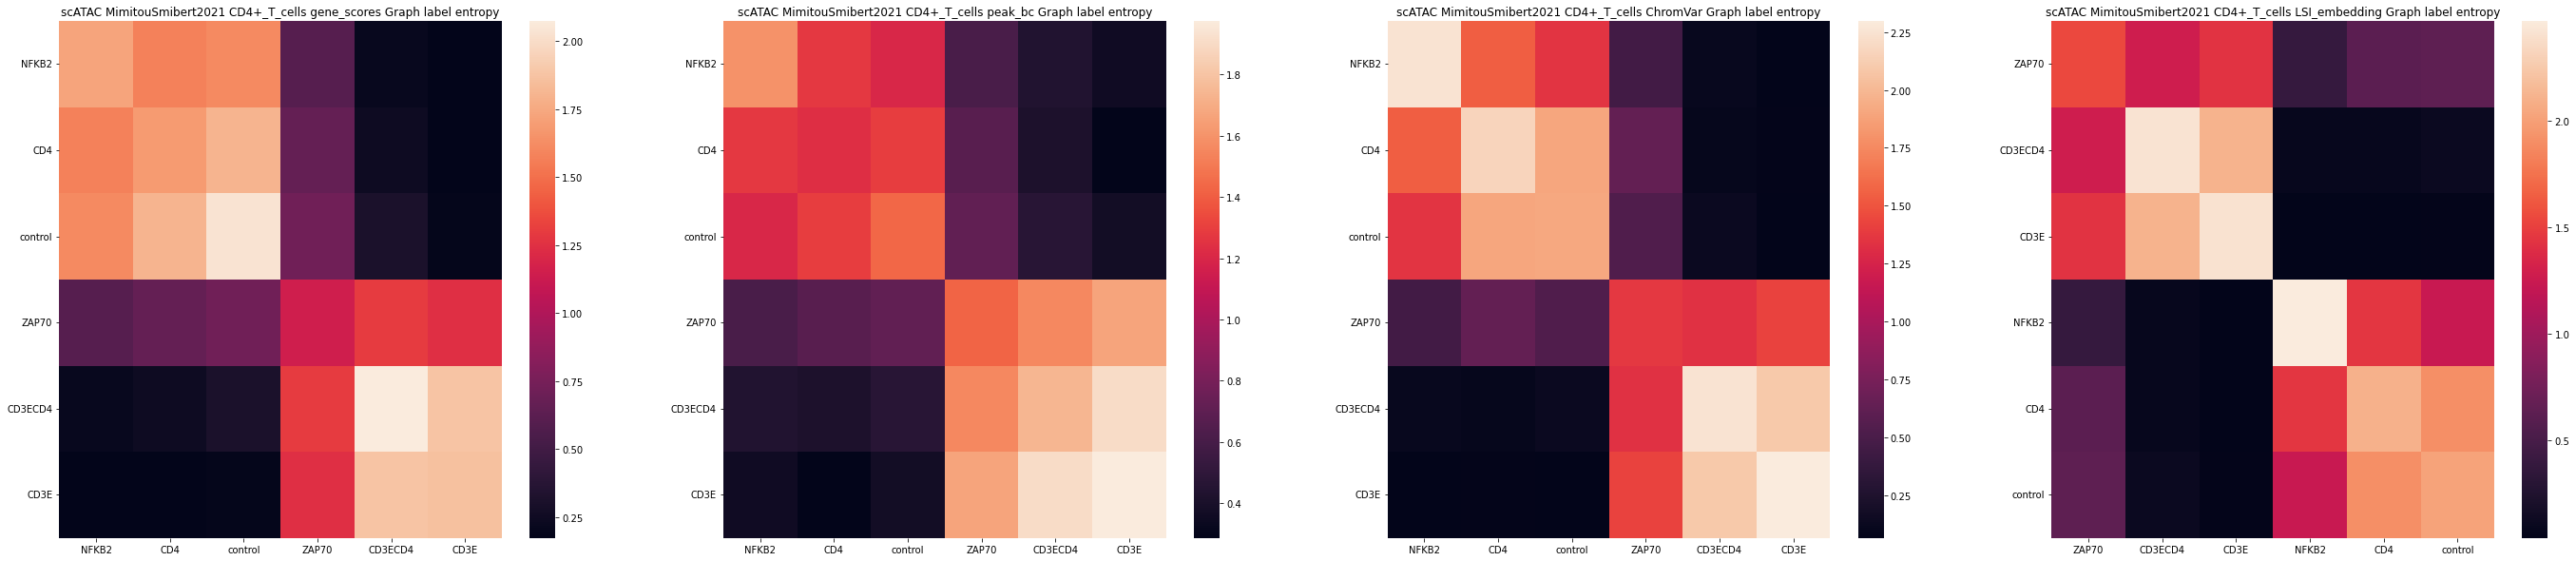

In [180]:
modes = ['gene_scores', 'peak_bc', 'ChromVar', 'LSI_embedding']  # markerpeak_target
dataset = 'MimitouSmibert2021'
lines = get_subfolders(f'{data_path}/scATAC/{dataset}', False)
fig, axs = pl.subplots(1, 4, figsize=[12 * 4, 10 * 1])
sims = {}
line=lines[0]
for mode, ax in zip(modes, axs):
    fct = eval(mode)
    sims[f'{dataset}_{line}_{mode}'] = fct(dataset, line, ax=ax, show=False)
pl.savefig(f'scATAC_{dataset}_graph_label_entropy.pdf')
pl.show()

# ZhaoSims2021

In [11]:
dataset = 'ZhaoSims2021'
# adata = read_from_singles(f"{data_path}{dataset}")
adata = sc.read(f"/fast/scratch/users/peidlis_c/perturbation_resource_paper/tmp_data_{dataset}.h5")

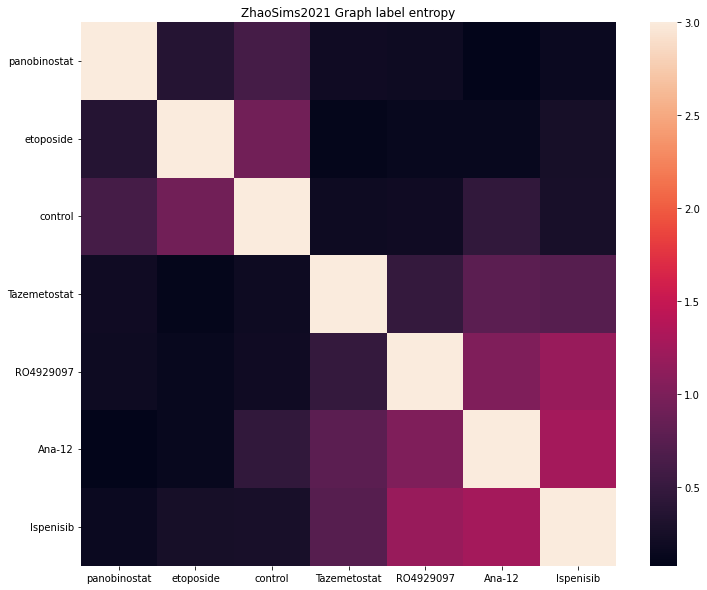

In [12]:
# Relative neighborship between cells of groups/perturbations across a KNN graph
sim = simil(adata, groupby='perturbation', plot=False, verbosity=50)
clear_output()
pl.figure(figsize=[12,10])
sns.heatmap(sim, vmax=3)
ax=pl.gca()
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
pl.title(f'{dataset} Graph label entropy')
# pl.savefig('../../figures/Graph_label_entropy_ZhaoSims2021.pdf', bbox_inches='tight')
pl.show()

# FrangiehIzar2021_RNA

In [15]:
dataset = 'FrangiehIzar2021_RNA'
# adata = read_from_singles(f"{data_path}{dataset}")
adata = sc.read(f"/fast/scratch/users/peidlis_c/perturbation_resource_paper/tmp_data_{dataset}.h5")

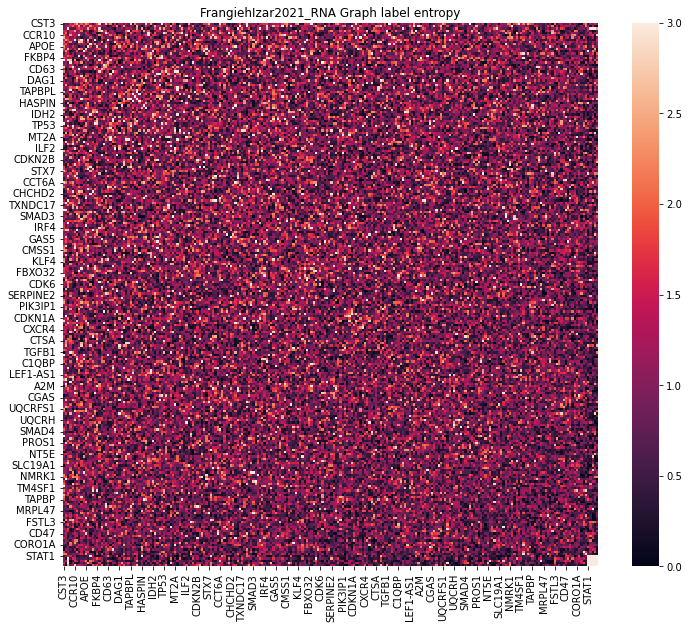

In [16]:
# Relative neighborship between cells of groups/perturbations across a KNN graph
sim = simil(adata, groupby='perturbation', plot=False, verbosity=50)
clear_output()
pl.figure(figsize=[12,10])
sns.heatmap(sim, vmax=3)
ax=pl.gca()
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
pl.title(f'{dataset} Graph label entropy')
# pl.savefig('../../figures/Graph_label_entropy_ZhaoSims2021.pdf', bbox_inches='tight')
pl.show()